## Imports

In [29]:

import numpy as np
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import  preprocessing
from sklearn.model_selection import train_test_split ## Cross- validation

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from prettytable import PrettyTable


# Data Preprocessing

## Reading the dataset

In [30]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Transform data

In [31]:
from sklearn.preprocessing import LabelEncoder
lbenc=LabelEncoder()
df['Month']= lbenc.fit_transform(df['Month'])
df['VisitorType']= lbenc.fit_transform(df['VisitorType'])

X = df.loc[:,df.columns!='Revenue'] #Independent Variables
Y = df.loc[:,'Revenue'] #Dependent Variable

## Normalization

Para la normalizacion se usara StandardScalar de tal modo que su distribucion tenga un valor medio de 0 y una desviacion estandar de 1.

z = (x - u) /s

In [32]:
X = (X - X.mean()) / (X.std())


## Balanced

Dado que la base de datos se encuentra desbalanceada, se considera el uso de submuestreo y sobremuestreo inteligente, ademas de una validacion estratificada

### Validacion boostraping

In [33]:
VALID_SIZE = 0.20

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True )
print('X_Train', X_train.shape)
print('y_train', y_train.shape)

X_Train (9864, 17)
y_train (9864,)


### SMOTE




In [34]:
sm = SMOTE( ratio = 0.5)

XS_train, ys_train = sm.fit_sample(X_train, y_train)
XS_test, ys_test = X_test, y_test

print('X_Train' + str(X_train.shape) + '--> XS_train ' +  str(XS_train.shape))
print('y_train'+ str(y_train.shape) + '-->  ys_train ' +  str(ys_train.shape))

print("Muestras por clase ")

print('Clase 0 ' + str(len(ys_train[(ys_train == 0)])))
print('Clase 1 ' + str(len(ys_train[(ys_train  == 1)])))

X_Train(9864, 17)--> XS_train (12541, 17)
y_train(9864,)-->  ys_train (12541,)
Muestras por clase 
Clase 0 8361
Clase 1 4180


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [35]:
def metrics(model, X_test ,Y_test, Y_pred):
    #Accuracy
    acurracy = accuracy_score(y_true = Y_test, y_pred = Y_pred)
    print("Acurracy : " + str(acurracy))
    #FScore
    f1 = f1_score(y_true = Y_test, y_pred = Y_pred)
    print("F1_Score : " + str(f1))
    #Reporte de clasificacion
    report = classification_report(Y_test, Y_pred)
    print("\nclassification report :\n",report )
    # Matriz de confusión
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    matrix = confusion_matrix(Y_test, Y_pred,normalize='true')
    sns.heatmap(matrix,annot=True,linecolor="black",linewidths=3, cmap="Blues")
    plt.title("Matriz de confusión",fontsize=20)
    
    #Sensibilidad y especificidad
    sensitivity = matrix[0,0]/(matrix[0,0]+matrix[0,1])
    print('Sensibilidad : ', sensitivity )
    specificity = matrix[1,1]/(matrix[1,0]+matrix[1,1])
    print('Especificidad : ', specificity)
    precition = matrix[0,0]/(matrix[0,0]+matrix[1,0])
    print('Precision : ', precition)
    eficiency = (matrix[1,1] + matrix[0,0])/(matrix[1,1]+matrix[0,0]+matrix[1,0]+matrix[0,1])
    print('Eficiencia : ', eficiency)
    
    
    # Curva ROC
    predicting_probabilites = model.predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(Y_test, predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Área bajo la curva:",roc_auc_score(Y_test,predicting_probabilites)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("\nCurva ROC",fontsize=20)   

    # Curva Precision-Recall 
    precision,recall,thresholds = precision_recall_curve(Y_test, predicting_probabilites)
    c_auc = auc(recall, precision)

    plt.subplot(223)
    plt.plot(recall,precision,label = ("Área bajo la curva:",c_auc),color = "r")
    plt.plot([0,1],[0.5,0.5],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("\nCurva Precision-Recall",fontsize=20)  

# Modelo - Gradient Boosting tree

Evaluamos el modelo con SMOTE

In [36]:
arboles = [10,20,30,40,50,60,70]
max_depth= [1,2,3,5, 10]
table = PrettyTable(['numero de arboles','Depth', 'Training Score', 'Testing Score', 'Accuracy','AUC'])
old_auc = 0
preds_selected = 0
model_selected = None
arboles_selected  = 0 
max_depth_selected = 0 
for depth in max_depth:
  for i in arboles:
    model = GradientBoostingClassifier(n_estimators=i , max_depth=depth)
    model.fit(XS_train, ys_train)
    ## Predict
    preds = model.predict(XS_test)
    predicting_probabilites = model.predict_proba(X_test)[:,1]
    precision,recall,thresholds = precision_recall_curve(ys_test, predicting_probabilites)
    c_auc = auc(recall, precision)
    if(c_auc > old_auc):
        model_selected = model
        preds_selected = preds
        max_depth_selected = depth
        arboles_selected = i
        old_auc = c_auc
    table.add_row([i,depth, model.score(XS_train, ys_train),model.score(XS_test, ys_test), accuracy_score(ys_test, preds),c_auc])



print(table)


+-------------------+-------+--------------------+--------------------+--------------------+--------------------+
| numero de arboles | Depth |   Training Score   |   Testing Score    |      Accuracy      |        AUC         |
+-------------------+-------+--------------------+--------------------+--------------------+--------------------+
|         10        |   1   | 0.8799936209233713 | 0.8710462287104623 | 0.8710462287104623 | 0.7008553178668933 |
|         20        |   1   | 0.8799936209233713 | 0.8710462287104623 | 0.8710462287104623 | 0.6589855330810834 |
|         30        |   1   | 0.8799936209233713 | 0.8710462287104623 | 0.8710462287104623 | 0.6745329956358092 |
|         40        |   1   | 0.8803923132126624 | 0.8722627737226277 | 0.8722627737226277 | 0.6707456856899476 |
|         50        |   1   | 0.8815883900805358 | 0.8722627737226277 | 0.8722627737226277 | 0.6798392337357563 |
|         60        |   1   | 0.8830236823219839 | 0.8722627737226277 | 0.87226277372262

Model selected with max_depth 3 arboles 60
Acurracy : 0.8901054339010543
F1_Score : 0.6881472957422324

classification report :
               precision    recall  f1-score   support

       False       0.95      0.92      0.93      2061
        True       0.64      0.74      0.69       405

    accuracy                           0.89      2466
   macro avg       0.80      0.83      0.81      2466
weighted avg       0.90      0.89      0.89      2466

Sensibilidad :  0.9199417758369723
Especificidad :  0.7382716049382716
Precision :  0.7785097724327974
Eficiencia :  0.829106690387622


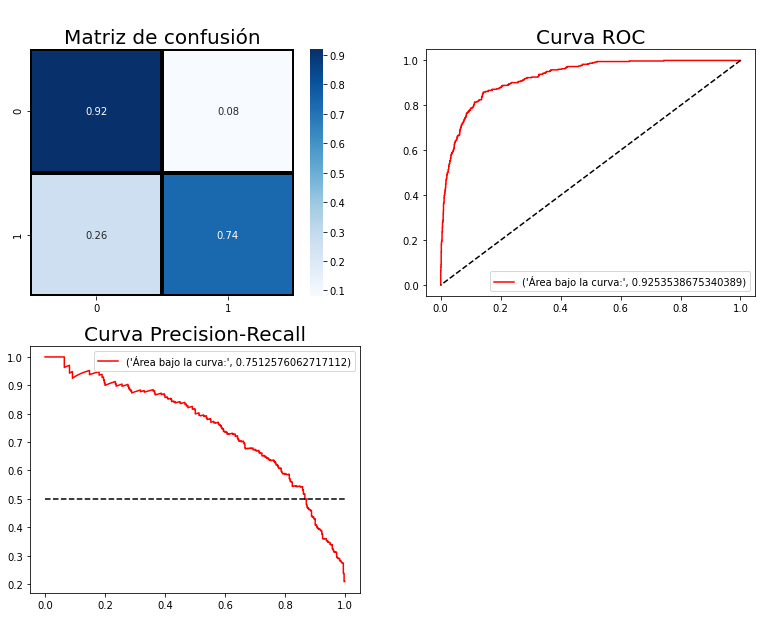

In [37]:
print("Model selected with max_depth " + str(max_depth_selected) + ' arboles ' + str(arboles_selected) )

metrics(model_selected, XS_test, ys_test, preds_selected)